In [1]:
import os
import sys
import time
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
import modin.pandas as md
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from matplotlib import cm

pd.set_option("display.float_format", "{:.6f}".format)
warnings.filterwarnings("ignore", ".*defaulting to pandas implementation.*")
notebook_dir = str(Path().resolve())
sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))
from historical_av_key_collector import keys_df, symbol, h5_name, available_dates
h5_path = os.path.join(notebook_dir,f'alphaVantage {symbol}.h5')
store = pd.HDFStore(h5_path)
store.close()


contracts data available for SPY:
0       2024-10-11
1       2024-10-10
2       2024-10-09
3       2024-10-08
4       2024-10-07
           ...    
3482    2010-12-06
3483    2010-12-03
3484    2010-12-02
3485           NaN
3486           NaN
Name: 0, Length: 3487, dtype: object

                   raw_data_key               surface_key  \
0     /date_2024_10_11/raw_data  /date_2024_10_11/surface   
1     /date_2024_10_10/raw_data  /date_2024_10_10/surface   
2     /date_2024_10_09/raw_data  /date_2024_10_09/surface   
3     /date_2024_10_08/raw_data  /date_2024_10_08/surface   
4     /date_2024_10_07/raw_data  /date_2024_10_07/surface   
...                         ...                       ...   
3480  /date_2010_12_08/raw_data                       NaN   
3481  /date_2010_12_07/raw_data                       NaN   
3482  /date_2010_12_06/raw_data                       NaN   
3483  /date_2010_12_03/raw_data                       NaN   
3484  /date_2010_12_02/raw_data                

# available time-series

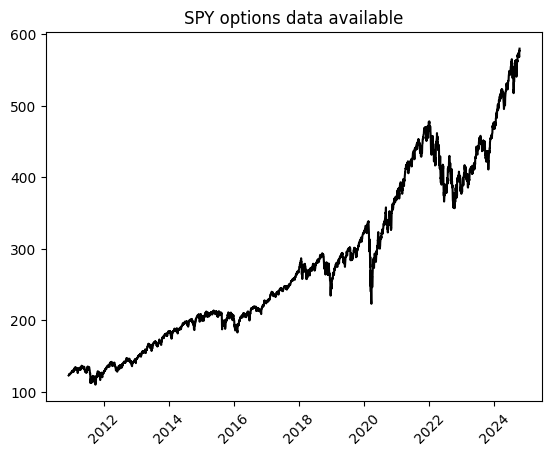

<Figure size 640x480 with 0 Axes>

In [2]:
spot_keys = keys_df.loc[:,['spot_price','date']].dropna()
spots = pd.Series(np.zeros(len(spot_keys)),index=spot_keys['date'])
spots.index = [datetime.strptime(date, '%Y-%m-%d') for date in spots.index.tolist()]
store.open()
for i,row in spot_keys.iterrows():
    spot_price = float(store[row['spot_price']].iloc[0])
    date = row['date']
    spots[date] = spot_price
store.close()
plt.figure()
plt.plot(spots,color='black')
plt.xticks(rotation=45)
plt.title(symbol + ' options data available')
plt.show()
plt.clf()

# volatility surface query

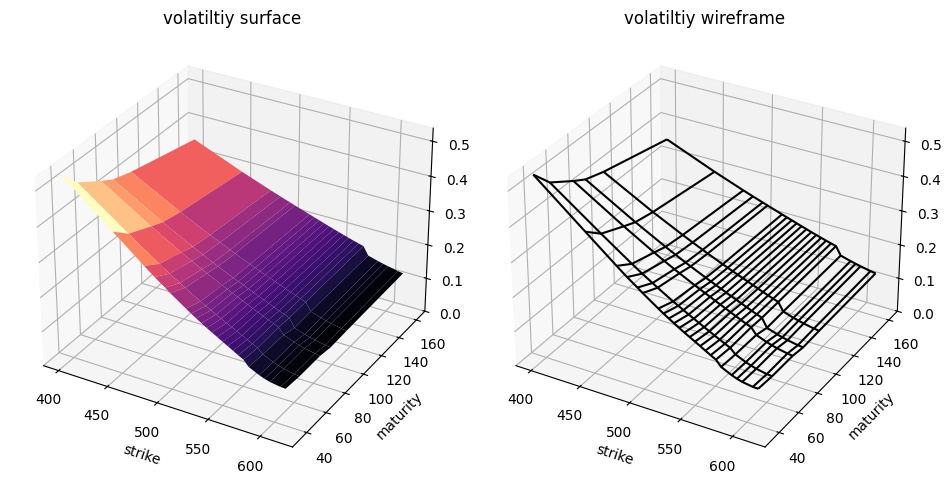

<Figure size 640x480 with 0 Axes>

In [3]:
from historical_av_plot_vol_surface import plot_vol_surface
surface_keys = keys_df.dropna(subset='surface_key').iloc[:1]
while True:
    try:
        store.open()
        surface = store[surface_keys.iloc[0]['surface_key']]
        break
    except OSError:
        time.sleep(2)
    finally:
        store.close()

plot_vol_surface(surface)

# calibrations

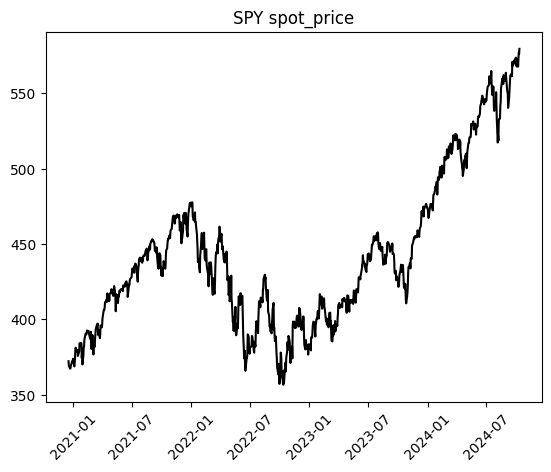

<Figure size 640x480 with 0 Axes>

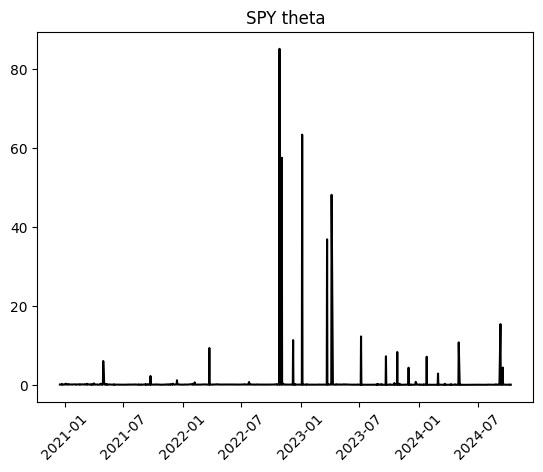

<Figure size 640x480 with 0 Axes>

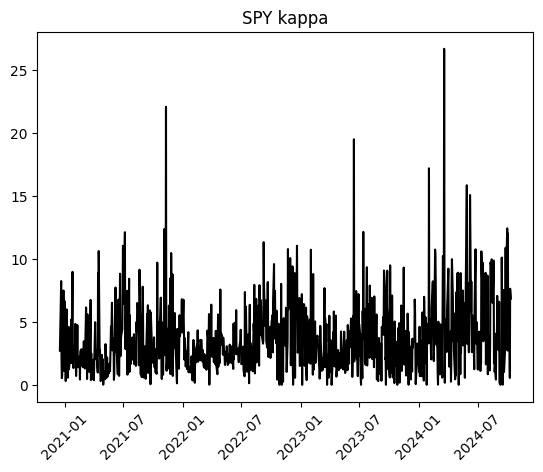

<Figure size 640x480 with 0 Axes>

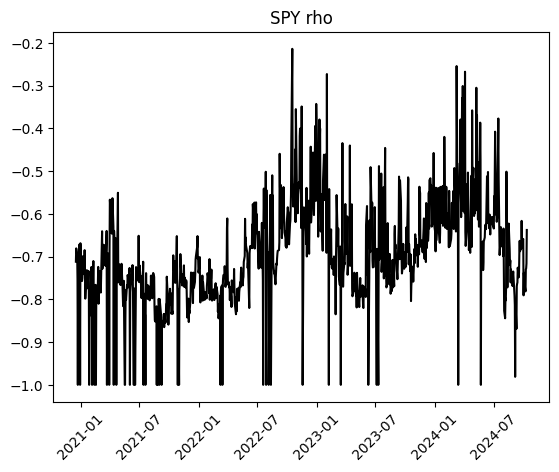

<Figure size 640x480 with 0 Axes>

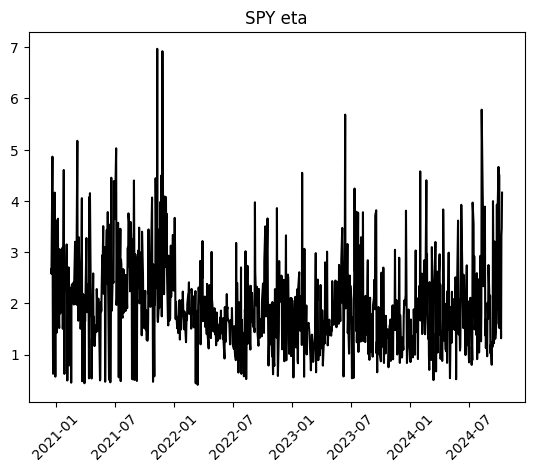

<Figure size 640x480 with 0 Axes>

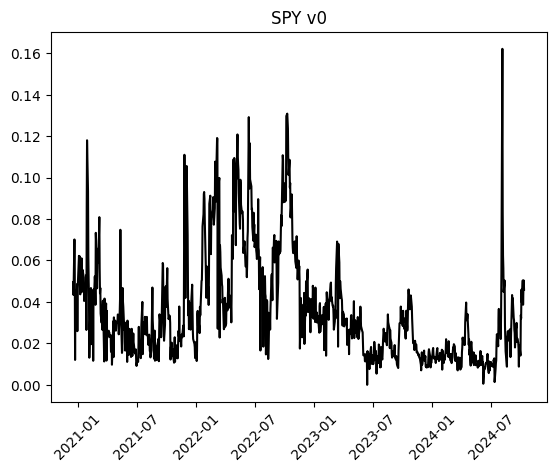


                    calculation_date   strike_price   market_price  \
count                        2430970 2430970.000000 2430970.000000   
mean   2022-10-09 06:48:32.668442624     413.050210      35.067689   
min              2020-12-17 00:00:00      25.000000       0.000000   
25%              2021-10-08 00:00:00     345.000000       0.430000   
50%              2022-08-29 00:00:00     414.000000       7.660000   
75%              2023-10-10 00:00:00     481.000000      42.420000   
max              2024-10-11 00:00:00    4898.000000     461.370000   
std                              NaN     113.970775      58.993298   

          volatility  days_to_maturity     spot_price  risk_free_rate  \
count 2430970.000000    2430970.000000 2430970.000000  2430970.000000   
mean        0.260058        110.071725     442.120641        0.040000   
min         0.006110         30.000000     356.560000        0.040000   
25%         0.160680         50.000000     404.360000        0.040000   
50%

<Figure size 640x480 with 0 Axes>

In [4]:
calibration_keys = keys_df.copy().dropna(subset=['calibration_key','parameter_key'])
calibrations = []
parameters = {}
while True:
    try:
        store.open()
        for i,row in calibration_keys.iterrows():
            calibrations.append(store[row['calibration_key']])
            parameters[row['date']] = store[row['parameter_key']]
        break
    except Exception as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()

calibrations = pd.concat(calibrations,ignore_index=True).dropna(subset='strike_price')
calibrations['calculation_date'] = pd.to_datetime(calibrations['calculation_date'],format='%Y-%m-%d')
calibrations = calibrations.set_index('calculation_date')
parameters = calibrations[['spot_price','theta','kappa','rho','eta','v0']].drop_duplicates()

for col in parameters.columns:
    plt.figure()
    plt.plot(calibrations[col], color='black')
    plt.xticks(rotation=45)
    plt.title(symbol + ' ' + col)
    plt.show()
    plt.clf()
print(f"\n{calibrations.reset_index().describe()}")

In [5]:
calibrations

,strike_price,w,market_price,volatility,days_to_maturity,spot_price,risk_free_rate,dividend_rate,theta,kappa,eta,rho,v0,moneyness,black_scholes,heston_price,error
calculation_date,,,,,,,,,,,,,,,,,
2024-10-11,260.000000,call,320.910000,0.245830,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.229154,320.575350,320.594510,0.019159
2024-10-11,260.000000,put,0.040000,0.868900,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,-0.551399,0.040439,0.019159,-0.021280
2024-10-11,265.000000,call,308.750000,0.241990,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.187094,315.594492,315.616372,0.021880
2024-10-11,265.000000,put,0.040000,0.849380,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,-0.542772,0.040437,0.021880,-0.018556
2024-10-11,270.000000,call,303.990000,0.238140,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.146593,310.613633,310.638560,0.024927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-17,545.000000,put,181.340000,0.268450,400,372.240000,0.040000,0.000000,0.100224,2.711930,2.670994,-0.711976,0.049504,0.464109,156.277906,150.294980,-5.982926
2020-12-17,550.000000,call,0.410000,0.170290,400,372.240000,0.040000,0.000000,0.100224,2.711930,2.670994,-0.711976,0.049504,-0.323200,0.775187,0.841206,0.066018
2020-12-17,550.000000,put,186.240000,0.272110,400,372.240000,0.040000,0.000000,0.100224,2.711930,2.670994,-0.711976,0.049504,0.477541,160.961939,155.012409,-5.949530
